<a href="https://colab.research.google.com/github/aymensrihi/deep-learning-projects/blob/main/VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import dataloader
import torch.nn as nn

In [35]:
transformation_operation=transforms.Compose([transforms.ToTensor()])

In [36]:
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transformation_operation)
val_dataset=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transformation_operation)



In [37]:
num_classes=10
batch_size=64
num_channels=1
img_size=28
patch_size=7
num_patches=(img_size // patch_size)**2
embedding_dim=64
attention_heads=4
transformer_blocks=4
learning_rate=0.001
epochs=5
mlp_hidden_nodes=128

print(num_patches)

16


In [38]:

train_loader=dataloader.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=dataloader.DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [39]:
class patch_embedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed=nn.Conv2d(num_channels,embedding_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self,x):
    x=self.patch_embed(x)
    x=x.flatten(2)
    x=x.transpose(1,2)
    return x
    #return self.patch_embed(x).flatten(2).transpose(1,2)

In [40]:
class transformerEncoder(nn.Module):
  def __init__(self) :
    super().__init__()
    self.layer_norm1=nn.LayerNorm(embedding_dim)
    self.layer_norm2=nn.LayerNorm(embedding_dim)
    self.multihead_attention=nn.MultiheadAttention(embedding_dim,attention_heads,batch_first=True)
    self.mlp=nn.Sequential(
        nn.Linear(embedding_dim,mlp_hidden_nodes),
        nn.GELU(),
        nn.Linear(mlp_hidden_nodes,embedding_dim)
    )
  def forward(self,x):
    residual1=x
    x=self.layer_norm1(x)
    x=self.multihead_attention(x,x,x)[0]
    x=x+residual1

    residual2=x
    x=self.layer_norm2(x)
    x=self.mlp(x)
    x=x+residual2

    return x

In [41]:
class MLP_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1=nn.LayerNorm(embedding_dim)
    self.mlp_head=nn.Linear(embedding_dim,num_classes)
  def forward(self,x):
    x=self.layer_norm1(x)
    x=self.mlp_head(x)

    return x



In [42]:
class visionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding=patch_embedding()
    self.cls_token=nn.Parameter(torch.randn(1,1,embedding_dim))
    self.position_embedding=nn.Parameter(torch.randn(1,1+num_patches,embedding_dim))
    self.transformer_blocks=nn.Sequential(*[transformerEncoder() for _ in range(transformer_blocks)])
    self.mlp_head=MLP_head()

  def forward(self,x):
    x=self.patch_embedding(x)
    B=x.size(0)
    class_tokens=self.cls_token.expand(B,-1,-1)
    x=torch.cat((class_tokens,x),dim=1)
    x=x+self.position_embedding
    x=self.transformer_blocks(x)
    x=x[:,0]
    x=self.mlp_head(x)

    return x

In [43]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=visionTransformer().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()

In [44]:
for epoch in range(epochs):
  model.train()
  total_loss=0
  correct_epoch=0
  total_epoch=0
  print(f"\nEpoch {epoch+1}")

  for batch_idx,(images,labels) in enumerate(train_loader):
    images,labels=images.to(device) , labels.to(device)

    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    preds=outputs.argmax(dim=1)
    correct=(preds==labels).sum().item()
    accuracy=100.0*correct/labels.size(0)

    correct_epoch+=correct
    total_epoch+=labels.size(0)

    if batch_idx % 100==0:
      print(f"Batch{batch_idx+1:3d}:Loss={loss.item():.4f},Accuracy={accuracy:.2f}%")
  epoch_acc=100.0*correct_epoch/total_epoch
  print(f"==>Epoch{epoch+1}Summary:Total Loss={total_loss:.4f},Accuracy={epoch_acc:.2f}%")


Epoch 1
Batch  1:Loss=2.2872,Accuracy=7.81%
Batch101:Loss=0.8252,Accuracy=81.25%
Batch201:Loss=0.3793,Accuracy=87.50%
Batch301:Loss=0.3452,Accuracy=90.62%
Batch401:Loss=0.2111,Accuracy=92.19%
Batch501:Loss=0.2757,Accuracy=95.31%
Batch601:Loss=0.1226,Accuracy=95.31%
Batch701:Loss=0.2219,Accuracy=93.75%
Batch801:Loss=0.3113,Accuracy=87.50%
Batch901:Loss=0.0338,Accuracy=100.00%
==>Epoch1Summary:Total Loss=355.6041,Accuracy=87.95%

Epoch 2
Batch  1:Loss=0.1471,Accuracy=96.88%
Batch101:Loss=0.0544,Accuracy=100.00%
Batch201:Loss=0.0482,Accuracy=98.44%
Batch301:Loss=0.0894,Accuracy=96.88%
Batch401:Loss=0.1734,Accuracy=92.19%
Batch501:Loss=0.0364,Accuracy=98.44%
Batch601:Loss=0.0291,Accuracy=100.00%
Batch701:Loss=0.1445,Accuracy=95.31%
Batch801:Loss=0.0262,Accuracy=100.00%
Batch901:Loss=0.1108,Accuracy=96.88%
==>Epoch2Summary:Total Loss=117.9731,Accuracy=96.21%

Epoch 3
Batch  1:Loss=0.0717,Accuracy=98.44%
Batch101:Loss=0.0263,Accuracy=100.00%
Batch201:Loss=0.0861,Accuracy=96.88%
Batch301:Los

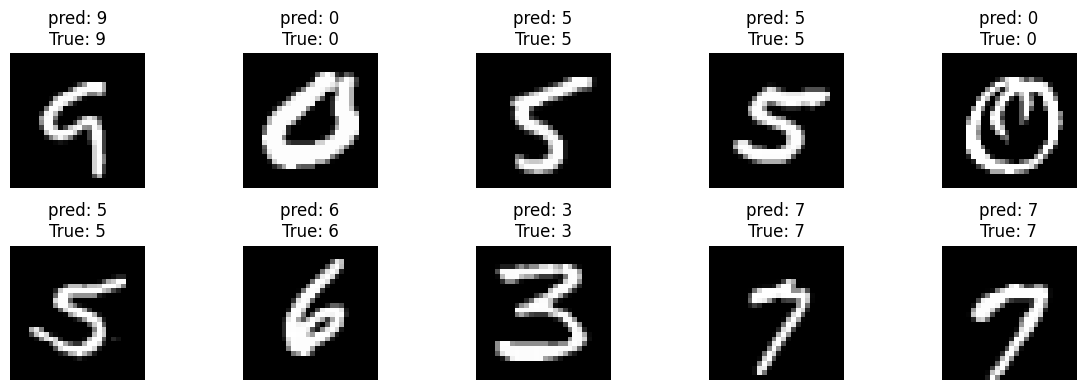

In [49]:
import matplotlib.pyplot as plt
model.eval()
images,labels=next(iter(val_loader))
images,labels=images.to(device),labels.to(device)
with torch.no_grad():
  output=model(images)
  preds=output.argmax(dim=1)
images=images.cpu()
preds=preds.cpu()
labels=labels.cpu()
#plot the first 10 images
plt.figure(figsize=(12,4))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(images[i].squeeze(),cmap='gray')
  plt.title(f"pred: {preds[i].item()}\nTrue: {labels[i].item()}")
  plt.axis('off')
plt.tight_layout()
plt.show()